In [1]:
import os
import sys

import logging
import re
import pathlib

import datetime

import numpy as np
import pandas as pd
from scipy.stats import pearsonr

import matplotlib.pyplot as plt

from pyplink import PyPlink
import seaborn as sns

import statsmodels.api as sm

import matplotlib.patches as patches
import matplotlib

from basic_tools import *

"""

jupyter nbconvert 5_association.ipynb --to script
python 5_association.py albumin 2 0

"""

'\n\njupyter nbconvert 5_association.ipynb --to script\npython 5_association.py albumin 2 0\n\n'

In [2]:
plink_KCHIP_HLA_AA_SNP_1000G=PyPlink(plink_KCHIP_HLA_AA_SNP_1000G_path)
plink_KCHIP_HLA_AA_SNP_1000G_fam=plink_KCHIP_HLA_AA_SNP_1000G.get_fam().astype({'fid':str,'iid':str}).rename(columns={'fid':'FID','iid':'IID'})
plink_KCHIP_HLA_AA_SNP_1000G_bim=plink_KCHIP_HLA_AA_SNP_1000G.get_bim()

In [3]:
#gene_bed_path='data/mart_export.txt'
#gene_bed=pd.read_csv(gene_bed_path,sep='\t')

#ENSG00000206337

In [4]:
#gene_bed[gene_bed['Gene stable ID']=='ENSG00000206337']

In [5]:
gene_bed_path='data/mart_export.txt'
gene_bed=pd.read_csv(gene_bed_path,sep='\t')
gene_bed=gene_bed.drop(columns='Exon stable ID')
gene_bed=gene_bed[(gene_bed['Gene start (bp)']>=plink_KCHIP_HLA_AA_SNP_1000G_bim.pos.min())&(gene_bed['Gene end (bp)']<=plink_KCHIP_HLA_AA_SNP_1000G_bim.pos.max())]
gene_bed=gene_bed.merge(right=pd.read_csv('data/mart_export_grch38.txt',sep='\t')[['Gene stable ID','Gene start (bp)','Gene end (bp)']].rename(columns=(lambda x:x+'38')),left_on='Gene stable ID',right_on='Gene stable ID38',how='left',)

gene_bed=gene_bed[(gene_bed['Transcript type']=='protein_coding')]
gene_bed=gene_bed[~gene_bed.duplicated(['Gene name','Gene start (bp)','Gene end (bp)'])]
print(gene_bed.shape)
gene_bed=gene_bed[~gene_bed.duplicated(['Gene name'])]
print(gene_bed.shape)

print(gene_bed.shape)

gene_assign=plink_KCHIP_HLA_AA_SNP_1000G_bim[['pos']]

for idx,row in gene_bed.iterrows():
    gene_assign[row['Gene name']]=0
    
for idx,row in gene_bed.iterrows():    
    gene_assign[row['Gene name']][(gene_assign['pos']>=row['Gene start (bp)'])&(gene_assign['pos']<=row['Gene end (bp)'])]=1

#gene_assign.columns=gene_assign.columns.str.replace('HLA-','HLA_')        
    
HLA_names=np.unique([i[0].split('_')[1] for i in plink_KCHIP_HLA_AA_SNP_1000G_bim[plink_KCHIP_HLA_AA_SNP_1000G_bim.index.str.contains('HLA_')].index.str.split('*')])

for HLA_name in HLA_names:
    gene_select=gene_assign[gene_assign.index.str.contains('HLA_'+HLA_name)|gene_assign.index.str.contains('SNPS_'+HLA_name)|gene_assign.index.str.contains('AA_'+HLA_name)]#print(gene_select.sort_values('pos').iloc[0],gene_select.sort_values('pos').iloc[-1])
    HLA_name='HLA-{}'.format(HLA_name)
    gene_assign[HLA_name][(gene_assign['pos']>=gene_select['pos'].min())&(gene_assign['pos']<=gene_select['pos'].max())]=1 

(209, 33)
(207, 33)
(207, 33)


/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [6]:
#gene_bed38[['Gene stable ID','Gene start (bp)','Gene end (bp)']].rename(columns=lambda x:x+'aa')

In [7]:
#gene_bed38[['Gene stable ID','Gene start (bp)','Gene end (bp)']].rename

In [8]:
catalog=pd.read_csv('data/ebi_alternative_0320.tsv',sep='\t')
catalog['DISEASE/TRAIT']=catalog['DISEASE/TRAIT'].str.lower()
catalog['MAPPED_TRAIT']=catalog['MAPPED_TRAIT'].str.lower()
catalog_chr6=catalog[catalog['CHR_ID']=='6']
catalog_chr6['CHR_POS']=catalog_chr6['CHR_POS'].astype(int)
catalog_chr6.columns

catalog_chr6_short=catalog_chr6.drop(columns=['DATE ADDED TO CATALOG','REPLICATION SAMPLE SIZE','DATE','REGION','FIRST AUTHOR','JOURNAL','CHR_ID','LINK','MERGED','RISK ALLELE FREQUENCY','PVALUE_MLOG','STRONGEST SNP-RISK ALLELE','95% CI (TEXT)','OR or BETA','PLATFORM [SNPS PASSING QC]','MAPPED_TRAIT_URI','GENOTYPING TECHNOLOGY','STUDY ACCESSION'])
catalog_chr6_short=catalog_chr6_short[(catalog_chr6_short['CHR_POS'].astype(int)>plink_KCHIP_HLA_AA_SNP_1000G_bim.pos.min()) & (catalog_chr6_short['CHR_POS']<plink_KCHIP_HLA_AA_SNP_1000G_bim.pos.max())]

len(catalog_chr6_short['DISEASE/TRAIT'].unique()),len(catalog_chr6_short['MAPPED_TRAIT'].unique())

catalog_chr6_short=catalog_chr6_short[catalog_chr6_short['P-VALUE'].astype(float)<5e-8]

japan_data=pd.read_csv('data/japan.tsv',sep='\t',index_col=0)
japan_data['DISEASE/TRAIT']=japan_data['DISEASE/TRAIT'].str.lower()
catalog_chr6_short=pd.concat([catalog_chr6_short,japan_data])

#catalog_chr6_short['GENE_CUSTOM'][(catalog_chr6_short['PUBMEDID']==30692682)]=catalog_chr6_short['CHR_POS'][(catalog_chr6_short['PUBMEDID']==30692682)].map(lambda x: pos_to_gene(x,mode='37'))    

#catalog_chr6_short[(catalog_chr6_short['PUBMEDID']==30692682)]#['GENE_CUSTOM']

/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (12,23,27,30) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [9]:
catalog_chr6_short['MAPPED_TRAIT'].unique()

array(["crohn's disease", 'ulcerative colitis', 'body height',
       'psoriasis', 'pulmonary function measurement, fev/fec ratio',
       'biliary liver cirrhosis', 'lung carcinoma',
       'rheumatoid arthritis', 'chronic lymphocytic leukemia',
       'hepatitis c induced liver cirrhosis', 'type i diabetes mellitus',
       'membranous glomerulonephritis', 'hepatocellular carcinoma',
       'lung adenocarcinoma', 'protein measurement', 'multiple sclerosis',
       'nasopharyngeal neoplasm', 'drug-induced liver injury',
       'hiv-1 infection', 'asthma', 'age-related macular degeneration',
       'stevens-johnson syndrome, toxic epidermal necrolysis',
       'pulmonary function measurement, forced expiratory volume',
       'renal system measurement', 'lipid measurement',
       'inflammatory bowel disease', 'platelet count',
       'seasonal allergic rhinitis', 'leukocyte count',
       "ulcerative colitis, crohn's disease",
       'systemic lupus erythematosus', 'vitiligo',
       

In [10]:
#japan_data.sort_values('P-VALUE')

In [11]:
def pos_to_gene(pos,mode='38'):
    if mode=='38':
        start='Gene start (bp)38'
        end='Gene end (bp)38'
    elif mode=='37':
        start='Gene start (bp)'
        end='Gene end (bp)'    
    else:
        raise
        
    gene_bed_select=gene_bed[(gene_bed[start]<pos) & (pos<gene_bed[end])]
    if gene_bed_select.shape[0]>0:
        return ','.join(gene_bed_select['Gene name'])
    
    front_back=[]
    gene_bed_select=gene_bed[gene_bed[end]<pos]
    gene_bed_select.loc[:,'dist']=(gene_bed_select[end]-pos).abs()
    if gene_bed_select.shape[0]>0:
        front_back.append(gene_bed_select.sort_values('dist')['Gene name'].iloc[0])
    
    gene_bed_select=gene_bed[gene_bed[start]>pos]
    gene_bed_select.loc[:,'dist']=(gene_bed_select[start]-pos).abs()
    if gene_bed_select.shape[0]>0:
        front_back.append(gene_bed_select.sort_values('dist')['Gene name'].iloc[0])
        
    return ','.join(front_back)

catalog_chr6_short['GENE_CUSTOM']=np.nan
catalog_chr6_short['GENE_CUSTOM'][(catalog_chr6_short['PUBMEDID']!=30692682)]=catalog_chr6_short['CHR_POS'][(catalog_chr6_short['PUBMEDID']!=30692682)].map(lambda x: pos_to_gene(x,mode='38'))    
catalog_chr6_short['GENE_CUSTOM'][(catalog_chr6_short['PUBMEDID']==30692682)]=catalog_chr6_short['CHR_POS'][(catalog_chr6_short['PUBMEDID']==30692682)].map(lambda x: pos_to_gene(x,mode='37'))    

/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [12]:
gene_unique=gene_bed['Gene name'].unique()
def gene_bed_match(gene):
    if type(gene)==float:
        return ''
    gene_list=[i.strip() for i in gene.split(',')]
    return ','.join(list(filter(lambda x: x in gene_unique,gene_list)))
    
catalog_chr6_short['REPORTED_GENE_CUSTOM']=catalog_chr6_short['REPORTED GENE(S)'].map(gene_bed_match)
catalog_chr6_short['GENE_CUSTOM_REPORTED_GENE_CUSTOM']=catalog_chr6_short[['GENE_CUSTOM','REPORTED_GENE_CUSTOM']].apply(lambda x: np.unique((x[0]+','+x[1]).strip(',').split(',')),axis=1)

In [13]:
catalog_chr6_short.to_csv('data/ebi_alternative_0320_munged.tsv',sep='\t')

In [14]:
result_all=pd.read_csv('data/temp_result_gene_annot.tsv',sep='\t')
#phenotype_name_significant_list=result_all[result_all['P_significant']==1]['phenotype_name'].unique()

In [16]:
phenotype_catalog_mapping={
    'FEV_predicted':{'include_list':['fev','expiratory'],'exclude_list':['ratio','fever']},
    'FVC_predicted':{'include_list':['fvc','vital'],'exclude_list':['ratio']},
    'albumin':{'include_list':['serum albumin level','albumin'],'exclude_list':['non-albumin','ratio','diabetes']},
    'allergic_disease':{'include_list':['allerg','atopic derma'],'exclude_list':[]},
    'alt':{'include_list':['alanine'],'exclude_list':['cancer']},
    'ast':{'include_list':['aspartat'],'exclude_list':['cancer']},
    'blood_in_urine':{'include_list':['hematuria','uri'],'exclude_list':[]},
    'bmi':{'include_list':['bmi','body mass index'],'exclude_list':['adjusted','blood','urate','bipolar','multiple','physical','smok']},
    'bun':{'include_list':['bun','nitr'],'exclude_list':[]},
    'creatinine':{'include_list':['creatinine'],'exclude_list':['ratio']},
    'diabetes':{'include_list':['diabetes'],'exclude_list':[',','medica']},
    'diastolic_blood_pressure':{'include_list':['diastolic'],'exclude_list':['time']},
    'systolic_blood_pressure':{'include_list':['systolic'],'exclude_list':['time']},
    'grip_strength':{'include_list':['grip'],'exclude_list':['time']},
    'hba1c':{'include_list':['a1c'],'exclude_list':[]},
    'hdl_cholesterol':{'include_list':['hdl','high density'],'exclude_list':[]},
    'height':{'include_list':['height'],'exclude_list':['growth']},
    'hematocrit':{'include_list':['hematocrit','hema'],'exclude_list':['growth']},
    'hemoglobin':{'include_list':['hemoglobin'],'exclude_list':['a1c']},
    'hip_circumference':{'include_list':['hip'],'exclude_list':['ratio','knee']},
    'hscrp':{'include_list':['hscrp','c-reactive'],'exclude_list':['low','or']},
    'hyperlipidemia':{'include_list':['cholesterol'],'exclude_list':[]},
    'hypertension':{'include_list':['hypertension'],'exclude_list':['to']},
    'mch':{'include_list':['corpuscular','mch'],'exclude_list':['volume','concentration','mchc']},
    'mcv':{'include_list':['corpuscular','mcv'],'exclude_list':['hemo']},
    'menopause_age':{'include_list':['menopause'],'exclude_list':[]},
    'platelet':{'include_list':['platelet'],'exclude_list':['trait','width','crit']},
    'protein_in_blood':{'include_list':['protein'],'exclude_list':['immuno','cholesterol','quantita','disease','wheat']},
    'pulse':{'include_list':['pulse'],'exclude_list':[]},
    'rbc':{'include_list':['red','erythrocy'],'exclude_list':['medication','width','lobe','tissue']},
    'thyroid_disease':{'include_list':['thyroi'],'exclude_list':['diabetes','medi','drug']},
    'total_cholesterol':{'include_list':['cholesterol'],'exclude_list':[]},
    'triglyceride':{'include_list':['triglycer'],'exclude_list':[]},
    'wbc':{'include_list':['white'],'exclude_list':['micro','wine']},
    'weight':{'include_list':['weight'],'exclude_list':['urate']},
}

In [17]:
catalog_chr6_short[catalog_chr6_short['DISEASE/TRAIT'].str.contains('nitr')|catalog_chr6_short['MAPPED_TRAIT'].str.contains('nitr')]

,Allele,CHR_POS,CNV,CONTEXT,Category,DISEASE/TRAIT,DOWNSTREAM_GENE_DISTANCE,DOWNSTREAM_GENE_ID,INITIAL SAMPLE SIZE,INTERGENIC,...,REPORTED GENE(S),SNPS,SNP_GENE_IDS,SNP_ID_CURRENT,STUDY,UPSTREAM_GENE_DISTANCE,UPSTREAM_GENE_ID,GENE_CUSTOM,REPORTED_GENE_CUSTOM,GENE_CUSTOM_REPORTED_GENE_CUSTOM


In [18]:
for phenotype_name in result_all[result_all['P_significant']==1]['phenotype_name'].unique():
    if phenotype_name!='bun':
        continue
    print(phenotype_name)
    
    catalog_temp=catalog_chr6_short.copy()
    catalog_check=np.zeros(catalog_temp.shape[0]).astype(bool)
    for include in phenotype_catalog_mapping[phenotype_name]['include_list']:
        catalog_check=catalog_check|(catalog_temp['DISEASE/TRAIT'].str.contains(include)|catalog_temp['MAPPED_TRAIT'].str.contains(include))
    #print(temp[['DISEASE/TRAIT','MAPPED_TRAIT']])
    for exclude in phenotype_catalog_mapping[phenotype_name]['exclude_list']:
        catalog_check=catalog_check&(~(catalog_temp['DISEASE/TRAIT'].str.contains(exclude)|catalog_temp['MAPPED_TRAIT'].str.contains(exclude)))
    
    print(catalog_temp[catalog_check][['PUBMEDID','DISEASE/TRAIT']])
    #or i in catalog_temp[catalog_check][['DISEASE/TRAIT','MAPPED_TRAIT']].iterrows():
    #   print(i[1].values)

bun
Empty DataFrame
Columns: [PUBMEDID, DISEASE/TRAIT]
Index: []


In [ ]:
for i in catalog_temp[catalog_check][['DISEASE/TRAIT','MAPPED_TRAIT']].iterrows():
    print(i[1].values)

In [290]:
#catalog_chr6_short[catalog_chr6_short['PUBMEDID']==25751624]

In [1419]:
#result_all[(result_all['P_significant']==1)].shape

In [22]:
phenotype_info=pd.read_csv('data/phenotype_info.tsv',sep='\t',index_col=0)

In [23]:
result_all_pub=result_all.copy()
result_all_pub['No.independent signals']=result_all_pub['phenotype_name'].map(lambda x: result_all[(result_all['P_significant']==1) & (result_all['phenotype_name']==x)].shape[0])
result_all_pub=result_all_pub[(result_all_pub['P_significant']==1) &(result_all_pub['step']==1)]

In [24]:
result_all_pub['phenotype_category']=phenotype_info.loc[result_all_pub['phenotype_name']]['phenotype_category'].values
result_all_pub['phenotype_type']=phenotype_info.loc[result_all_pub['phenotype_name']]['phenotype_type'].values
result_all_pub['phenotype_name_publication']=phenotype_info.loc[result_all_pub['phenotype_name']]['phenotype_name_publication'].values

In [26]:
#result_all_pub['phenotype']

In [ ]:
result_all_pub['A1 frequency(case/control)']=

In [1400]:
result_all_pub.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'phenotype_name', 'samples(case/control)',
       'step', 'condition', 'marker_name', 'note', 'term', 'POS', 'A1', 'A2',
       'A1_freq_case', 'A1_freq_control', 'multi_allele', 'nobs', 'Z', 'coef',
       'std', 'chisq', 'df', 'P', 'P_significant', 'gene_genehow', 'gene',
       'genehow', 'phenotype_category', 'phenotype_type',
       'phenotype_name_publication'],
      dtype='object')

In [1425]:
result_all_pub_save=result_all_pub[['phenotype_type','phenotype_category','phenotype_name_publication','samples(case/control)',
       'No.independent signals', 'marker_name', 'POS', 'A1', 'A2','gene','A1_freq_case', 'A1_freq_control','coef','std', 'chisq', 'df', 'P']]

In [1427]:
result_all_pub_save.to_csv("result_pub.tsv",sep='\t')

# Novelty check

In [387]:
catalog_temp['GENE_CUSTOM_REPORTED_GENE_CUSTOM']#.values#+[]

1855        [ZKSCAN3, ZSCAN31]
12097                [SLC44A4]
12099               [HLA-DQB1]
12115     [HLA-DQA2, HLA-DQB1]
35507            [GRM4, HMGA1]
35706                [ZSCAN31]
35707                   [AGER]
35708               [HLA-DQB1]
36103                [ZSCAN31]
36104                   [AGER]
36105               [HLA-DQB1]
140196              [HLA-DQB1]
140208    [HLA-DQA2, HLA-DQB1]
Name: GENE_CUSTOM_REPORTED_GENE_CUSTOM, dtype: object

In [1091]:
novelty_check_list=[]

for phenotype_name in result_all[result_all['P_significant']==1]['phenotype_name'].unique():   
    #print('-----------------------')
    if phenotype_name!='FEV_predicted':
        pass#continue
    
    our_temp=result_all[(result_all['P_significant']==1)&(result_all['phenotype_name']==phenotype_name)]

    catalog_temp=catalog_chr6_short.copy()
    catalog_check=np.zeros(catalog_temp.shape[0]).astype(bool)
    for include in phenotype_catalog_mapping[phenotype_name]['include_list']:
        catalog_check=catalog_check|(catalog_temp['DISEASE/TRAIT'].str.contains(include)|catalog_temp['MAPPED_TRAIT'].str.contains(include))
    #print(temp[['DISEASE/TRAIT','MAPPED_TRAIT']])
    for exclude in phenotype_catalog_mapping[phenotype_name]['exclude_list']:
        catalog_check=catalog_check&(~(catalog_temp['DISEASE/TRAIT'].str.contains(exclude)|catalog_temp['MAPPED_TRAIT'].str.contains(exclude)))

    catalog_temp=catalog_temp[catalog_check][['PUBMEDID','DISEASE/TRAIT','MAPPED_TRAIT','SNPS','CHR_POS','REPORTED GENE(S)','GENE_CUSTOM_REPORTED_GENE_CUSTOM']]#['CHR_POS'])#['GENE_CUSTOM_REPORTED_GENE_CUSTOM'])
    catalog_temp['genehow']='reported_gene+on_gene,nearest' 
    
    #print(phenotype_name,catalog_temp.shape,catalog_temp)
    is_novel=lambda gene: ('-' if len(set(gene.split(',')).intersection(set(np.unique(np.concatenate(catalog_temp['GENE_CUSTOM_REPORTED_GENE_CUSTOM'].values)))))>0 else 'novel') if catalog_temp.shape[0]>0 else 'novel'
        
    our_temp=our_temp[['marker_name','POS','gene','genehow']].rename(columns={'marker_name':'SNPS','POS':'CHR_POS','gene':'GENE_CUSTOM_REPORTED_GENE_CUSTOM'})
    our_temp['PUBMEDID']='OUR_RESULT'
    our_temp['novelty']=our_temp['GENE_CUSTOM_REPORTED_GENE_CUSTOM'].map(is_novel)

    
    our_catalog_concat=pd.concat([our_temp,catalog_temp])
    our_catalog_concat['phenotype_name']=phenotype_name
    our_catalog_concat=our_catalog_concat[['phenotype_name','PUBMEDID','DISEASE/TRAIT','MAPPED_TRAIT','SNPS','CHR_POS','REPORTED GENE(S)','GENE_CUSTOM_REPORTED_GENE_CUSTOM','genehow','novelty']]
    
    novelty_check_list.append(our_catalog_concat)
    

/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [1092]:
pd.concat(novelty_check_list)['GENE_CUSTOM_REPORTED_GENE_CUSTOM'].iloc[1]

array(['ZKSCAN3', 'ZSCAN31'], dtype='<U7')

In [1093]:
pd.concat(novelty_check_list).to_csv('data/temp_result_novelty_check.tsv',sep='\t')

In [803]:
#phenotype_category_color

# Phewas plot 

In [1164]:
phewas_data=result_all[result_all['P_significant']==1][['phenotype_name','gene','P']]
phewas_data.shape

(66, 3)

In [1165]:
phewas_data[phewas_data['phenotype_name']=='hematocrit']

,phenotype_name,gene,P
77,hematocrit,"RNF5,AGER",9.197860e-13
78,hematocrit,HLA-B,1.049540e-09
79,hematocrit,HLA-F,9.911020e-09


In [1166]:
phewas_data.loc[phewas_data.index.max()+1]=['hematocrit','RNF5',9.197860e-13]
phewas_data.loc[phewas_data.index.max()+1]=['hematocrit','AGER',9.197860e-13]
phewas_data=phewas_data[~((phewas_data['phenotype_name']=='hematocrit') &(phewas_data['gene']=='RNF5,AGER'))]
phewas_data.shape

(67, 3)

In [1167]:
phewas_data[phewas_data.duplicated(['phenotype_name','gene'],keep=False)]

,phenotype_name,gene,P
112,platelet,BAK1,1.579220e-69
114,platelet,BAK1,1.105480e-33


In [1168]:
phewas_data[phewas_data.duplicated(['phenotype_name','gene'])]

,phenotype_name,gene,P
114,platelet,BAK1,1.105480e-33


In [1169]:
phewas_data=phewas_data[~phewas_data.duplicated(['phenotype_name','gene'])]
phewas_data.shape

(66, 3)

In [1170]:
phewas_data_2d=phewas_data.pivot(index='phenotype_name',columns='gene',values='P')

In [1171]:
phewas_data_2d=phewas_data_2d.applymap(lambda x: -np.log10(x))

In [1172]:
phewas_data_2d=phewas_data_2d[gene_bed.set_index('Gene name').loc[phewas_data_2d.columns].sort_values('Gene start (bp)').index]
phewas_data_2d=phewas_data_2d.loc[phenotype_info.loc[phewas_data_2d.index].sort_values(['phenotype_type','phenotype_category']).index]
#phewas_data_2d.index=phenotype_info.loc[phewas_data_2d.index]['phenotype_name_publication']

In [1198]:
len(phewas_data['phenotype_name'].unique())

35

In [1196]:
len(phewas_data['gene'].unique())

27

In [1191]:
phewas_data_2d.shape

(35, 27)

In [1173]:
phewas_data_2d.max().max(),phewas_data_2d.min().min()

(75.68871882374123, 7.336711897616068)

In [1174]:
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
from matplotlib import cm
import matplotlib.pyplot as plt

custom_cmap=cm.get_cmap('rainbow')
custom_cmap_array=custom_cmap(np.linspace(0, 1, 7))
#custom_cmap_array=np.concatenate([np.array([[1,1,1,1]]*100),custom_cmap_array],axis=0)
custom_cmap_array=np.array([[min(rgba[0]+0.1,1),min(rgba[1]+0.1,1),min(rgba[2]+0.1,1),rgba[3]] for rgba in custom_cmap_array])
#custom_cmap_array[0][-1]=0
custom_cmap_array[0]=[0.8,0.8,1,1]
#custom_cmap_array[0]=custom_cmap_array[0]*2
#custom_cmap_array=
#custom_cmap_array=[custom_cmap_array[0],custom_cmap_array[20],custom_cmap_array[40],custom_cmap_array[60]]

#custom_cmap_array=custom_cmap_array[30:]
custom_cmap = ListedColormap(custom_cmap_array)

"""
#boundaries = [0, 10, 15, 20, 30, 50,100]  # custom boundaries
#boundaries = [0, 0.1,0.2,0.3,,0.4,1]  # custom boundaries
#custom_cmap=cm.get_cmap('rainbow')
#custom_cmap_array=custom_cmap(np.linspace(0, 1, len(boundaries)))
# here I generated twice as many colors, 
# so that I could prune the boundaries more clearly
#hex_colors = sns.light_palette('navy', n_colors=len(boundaries) * 2 + 2, as_cmap=False).as_hex()
#hex_colors = [hex_colors[i] for i in range(0, len(hex_colors), 2)]

colors=list(zip(boundaries, custom_cmap_array))

custom_cmap = LinearSegmentedColormap.from_list(
    name='custom_navy',
    colors=colors,
)
"""

"""
viridisBig = cm.get_cmap('rainbow')

newcmp = ListedColormap(viridisBig(np.linspace(0, 1, 512)))

def plot_examples(cms):
    np.random.seed(19680801)
    data = np.random.randn(30, 30)

    fig, axs = plt.subplots(1, 2, figsize=(6, 3), constrained_layout=True)
    for [ax, cmap] in zip(axs, cms):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=-4, vmax=4)
        fig.colorbar(psm, ax=ax)
    plt.show()

plot_examples([newcmp])
"""
    
    
"""
boundaries = [0, 0.1,0.2,0.3,,0.4,1]  # custom boundaries
custom_cmap=cm.get_cmap('rainbow')
custom_cmap_array=custom_cmap(np.linspace(0, 1, len(boundaries)))
# here I generated twice as many colors, 
# so that I could prune the boundaries more clearly
#hex_colors = sns.light_palette('navy', n_colors=len(boundaries) * 2 + 2, as_cmap=False).as_hex()
#hex_colors = [hex_colors[i] for i in range(0, len(hex_colors), 2)]

colors=list(zip(boundaries, custom_cmap_array))

custom_cmap = LinearSegmentedColormap.from_list(
    name='custom_navy',
    colors=colors,
)
"""

"\nboundaries = [0, 0.1,0.2,0.3,,0.4,1]  # custom boundaries\ncustom_cmap=cm.get_cmap('rainbow')\ncustom_cmap_array=custom_cmap(np.linspace(0, 1, len(boundaries)))\n# here I generated twice as many colors, \n# so that I could prune the boundaries more clearly\n#hex_colors = sns.light_palette('navy', n_colors=len(boundaries) * 2 + 2, as_cmap=False).as_hex()\n#hex_colors = [hex_colors[i] for i in range(0, len(hex_colors), 2)]\n\ncolors=list(zip(boundaries, custom_cmap_array))\n\ncustom_cmap = LinearSegmentedColormap.from_list(\n    name='custom_navy',\n    colors=colors,\n)\n"

In [474]:
phenotype_info=pd.read_csv('data/phenotype_info.tsv',sep='\t',index_col=0)

#data_out_assoc_phenotype_path=data_out_assoc_path+phenotype_name+'/'
#pathlib.Path(data_out_assoc_phenotype_path).mkdir(parents=True, exist_ok=True)

#for i in binary_continuous_traits:
#    if not os.path.exists('data/out_assoc/{}/step_01.plink.PHENO2.glm.linear'.format(i)) and not os.path.exists('data/out_assoc/{}/step_01.plink.PHENO2.glm.logistic'.format(i)):
#        print(i)

#pheno=pd.read_csv(data_out_pheno_path+phenotype_name+'.phe',sep='\t',names=['FID','IID','pheno'])
#phenotype_type='binary' if len(pheno['pheno'][pheno['pheno']!=-9].value_counts())<3 else 'continuous'
#phenotype_type
#for phenotype_name,row in phenotype_info.iterrows():
#    pheno=pd.read_csv(data_out_pheno_path+phenotype_name+'.phe',sep='\t',names=['FID','IID','pheno'])
#    phenotype_type='binary' if len(pheno['pheno'][pheno['pheno']!=-9].value_counts())<3 else 'continuous'
#    phenotype_info['phenotype_type'][phenotype_name]=phenotype_type    

In [1199]:
phenotype_category_color=pd.Series(index=phenotype_info.loc[phewas_data_2d.index]['phenotype_category'].unique())
cnt=1
for phenotype_category,row in phenotype_category_color.items():
    if 'Other' in phenotype_category:
        phenotype_category_color[phenotype_category]=0
        
    elif (phenotype_info.loc[phewas_data_2d.index]['phenotype_category']==phenotype_category).sum()==1:
        phenotype_category_color[phenotype_category]=0
    else:
        phenotype_category_color[phenotype_category]=cnt;cnt+=1

cmap_temp=plt.cm.brg(np.linspace(0,1,phenotype_category_color.max()))
cmap_temp=[[color[0]*0.6,color[1]*0.6,color[2]*0.6,color[3]] for color in cmap_temp]
np.random.shuffle(cmap_temp)
cmap_temp=np.concatenate(([[0,0,0,1]],cmap_temp))   

phenotype_category_color=phenotype_category_color.map(lambda x: cmap_temp[int(x)])

/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  if sys.path[0] == '':


In [1200]:
def gene_to_color(gene_name):

    if gene_name in ['HLA-A','HLA-B','HLA-C']:
        #color='#fa3c14'
        #250, 58, 20
        color=1/256*np.array((250,58,20,256))
    elif gene_name in ['HLA-DPA1', 'HLA-DPB1','HLA-DQA1', 'HLA-DQB1','HLA-DRB1','HLA-DRA']:
        #color='#2850c8'
        color=1/256*np.array((40, 80, 200,256))
    elif gene_name in ['HLA-F', 'HLA-G', 'HLA-E', 'HLA-DRB5', 'HLA-DQA2', 'HLA-DQB2', 'HLA-DOB', 'HLA-DMB', 'HLA-DMA', 'HLA-DOA', 'MICA','MICB','TAP2','TAP1']:
        #color='#28c828'
        color=1/256*np.array((40, 200, 40,256))
    else:
        #color='#fafac8'
        color=1/256*np.array((250, 250, 200,256))
        color[:3]=color[:3]*0.3
    return color
    
    

In [1201]:
phewas_data_2d_count=(phewas_data_2d>0).sum().to_frame().reset_index()

In [1202]:
phewas_data_2d_count['color']=phewas_data_2d_count['gene'].map(gene_to_color)

In [1203]:
phewas_data_2d_count

,gene,0,color
0,SCAND3,1,"[0.29296875, 0.29296875, 0.234375, 1.0]"
1,TRIM27,2,"[0.29296875, 0.29296875, 0.234375, 1.0]"
2,C6orf100,1,"[0.29296875, 0.29296875, 0.234375, 1.0]"
3,UBD,1,"[0.29296875, 0.29296875, 0.234375, 1.0]"
4,HLA-F,1,"[0.15625, 0.78125, 0.15625, 1.0]"
5,HLA-A,1,"[0.9765625, 0.2265625, 0.078125, 1.0]"
6,HLA-E,1,"[0.15625, 0.78125, 0.15625, 1.0]"
7,IER3,1,"[0.29296875, 0.29296875, 0.234375, 1.0]"
8,MUC22,2,"[0.29296875, 0.29296875, 0.234375, 1.0]"
9,HLA-C,5,"[0.9765625, 0.2265625, 0.078125, 1.0]"


In [1183]:
gene_bed.set_index('Gene name').loc['RNF5']

Gene stable ID                                                                  ENSG00000204308
Gene stable ID version                                                        ENSG00000204308.6
Transcript stable ID                                                            ENST00000375094
Transcript stable ID version                                                  ENST00000375094.3
Gene start (bp)                                                                        32146131
Gene end (bp)                                                                          32151930
Transcript start (bp)                                                                  32146131
Transcript end (bp)                                                                    32148570
Protein stable ID                                                               ENSP00000364235
Protein stable ID version                                                     ENSP00000364235.3
Gene description                        

In [1184]:
result_all['gene'].unique()

array([nan, 'HMGA1', 'HLA-C', 'HLA-DQB1', 'MICA', 'HLA-DRB1', 'HLA-DPB1',
       'HLA-DRB5', 'HLA-DQA1', 'TRIM27', 'HLA-E', 'NOTCH4', 'UHRF1BP1',
       'MUC22', 'SCAND3', 'TAF11', 'IER3', 'RNF5,AGER', 'HLA-B', 'HLA-F',
       'C6orf100', 'MICB', 'BAK1', 'C6orf10', 'UBD', 'ATF6B', 'HLA-A'],
      dtype=object)

In [1185]:
phewas_data_2d.columns

Index(['SCAND3', 'TRIM27', 'C6orf100', 'UBD', 'HLA-F', 'HLA-A', 'HLA-E',
       'IER3', 'MUC22', 'HLA-C', 'HLA-B', 'MICA', 'MICB', 'ATF6B', 'RNF5',
       'AGER', 'NOTCH4', 'C6orf10', 'HLA-DRB5', 'HLA-DRB1', 'HLA-DQA1',
       'HLA-DQB1', 'HLA-DPB1', 'BAK1', 'HMGA1', 'UHRF1BP1', 'TAF11'],
      dtype='object', name='gene')

In [1277]:
phewas_data_2d_columns_catalog=[]
for gene_name in phewas_data_2d.columns:
    
    if gene_name!='HMGA1':
        pass#continue
    print(gene_name)
    catalog_chr6_short_select=catalog_chr6_short[catalog_chr6_short['GENE_CUSTOM_REPORTED_GENE_CUSTOM'].map(lambda x: gene_name in x)]
    print(catalog_chr6_short_select.shape)

    catalog_chr6_short_select=catalog_chr6_short_select[~catalog_chr6_short_select.duplicated('MAPPED_TRAIT')]
    print(catalog_chr6_short_select.shape)
    
    catalog_chr6_short_select=catalog_chr6_short_select[~catalog_chr6_short_select.duplicated('DISEASE/TRAIT')]
    print(catalog_chr6_short_select.shape)    
    #catalog_chr6_short_select=catalog_chr6_short_select[~catalog_chr6_short_select.duplicated('PUBMEDID')]
    #catalog_chr6_short_select=catalog_chr6_short_select[~catalog_chr6_short_select.duplicated('PUBMEDID')]
    catalog_chr6_short_select['gene_name']=gene_name
    phewas_data_2d_columns_catalog.append(catalog_chr6_short_select)
    print('---------------------------------')

SCAND3
(57, 25)
(23, 25)
(23, 25)
---------------------------------
TRIM27
(68, 25)
(29, 25)
(28, 25)
---------------------------------
C6orf100
(11, 25)
(10, 25)
(10, 25)
---------------------------------
UBD
(17, 25)
(10, 25)
(9, 25)
---------------------------------
HLA-F
(37, 25)
(21, 25)
(21, 25)
---------------------------------
HLA-A
(107, 25)
(65, 25)
(64, 25)
---------------------------------
HLA-E
(50, 25)
(24, 25)
(23, 25)
---------------------------------
IER3
(44, 25)
(20, 25)
(20, 25)
---------------------------------
MUC22
(56, 25)
(33, 25)
(31, 25)
---------------------------------
HLA-C
(152, 25)
(86, 25)
(81, 25)
---------------------------------
HLA-B
(289, 25)
(138, 25)
(131, 25)
---------------------------------
MICA
(219, 25)
(112, 25)
(109, 25)
---------------------------------
MICB
(153, 25)
(72, 25)
(69, 25)
---------------------------------
ATF6B
(37, 25)
(16, 25)
(14, 25)
---------------------------------
RNF5
(24, 25)
(8, 25)
(8, 25)
------------------------

In [1377]:
phewas_data_2d_columns_catalog_all.to_csv('data/temp_catalog_match.tsv',sep='\t',index=None)

In [1364]:
phewas_data_2d_columns_catalog_all=pd.concat(phewas_data_2d_columns_catalog)

phewas_data_2d_columns_catalog_all=phewas_data_2d_columns_catalog_all[[phewas_data_2d_columns_catalog_all.columns[-1]]+phewas_data_2d_columns_catalog_all.columns[:-1].tolist()]

#catalog_chr6_short_select#['MAPPED_TRAIT']

phewas_data_2d.columns

phewas_data_2d_columns_catalog_all_count=phewas_data_2d_columns_catalog_all['gene_name'].value_counts().to_frame().reset_index()

phewas_data_2d_columns_catalog_all_count=phewas_data_2d_columns_catalog_all_count.loc[phewas_data_2d_columns_catalog_all_count.reset_index().set_index('index').loc[phewas_data_2d_count['gene']]['level_0'].values]

phewas_data_2d_columns_catalog_all_count['color']=phewas_data_2d_columns_catalog_all_count['index'].map(gene_to_color)

phewas_data_2d_count.shape

(27, 3)

In [1267]:
phewas_data_2d_columns_catalog_all_count.shape

(27, 3)

In [1356]:
#phewas_data_2d_columns_catalog_all_count
#phewas_data_2d_columns_catalog_all_count
#phewas_data_2d_columns_catalog_all_count

In [1357]:
#phewas_data_2d_columns_catalog_all[phewas_data_2d_columns_catalog_all['gene_name']=='HMGA1'][['DISEASE/TRAIT','MAPPED_TRAIT']]

In [1371]:
phewas_data_2d_columns_catalog_all_count['color']=phewas_data_2d_columns_catalog_all_count['color'].map(lambda x: [min(x[0]+0.3,1),min(x[1]+0.3,1),min(x[2]+0.6,1),x[3]])


In [1372]:
phewas_data_2d_columns_catalog_all_count['color']

16    [0.6929687499999999, 0.79296875, 1, 1.0]
14    [0.6929687499999999, 0.79296875, 1, 1.0]
23    [0.6929687499999999, 0.79296875, 1, 1.0]
24    [0.6929687499999999, 0.79296875, 1, 1.0]
17             [0.5562499999999999, 1, 1, 1.0]
7                       [1, 0.7265625, 1, 1.0]
15             [0.5562499999999999, 1, 1, 1.0]
19    [0.6929687499999999, 0.79296875, 1, 1.0]
12    [0.6929687499999999, 0.79296875, 1, 1.0]
5                       [1, 0.7265625, 1, 1.0]
1                       [1, 0.7265625, 1, 1.0]
3              [0.5562499999999999, 1, 1, 1.0]
6              [0.5562499999999999, 1, 1, 1.0]
22    [0.6929687499999999, 0.79296875, 1, 1.0]
25    [0.6929687499999999, 0.79296875, 1, 1.0]
20    [0.6929687499999999, 0.79296875, 1, 1.0]
10    [0.6929687499999999, 0.79296875, 1, 1.0]
9     [0.6929687499999999, 0.79296875, 1, 1.0]
8              [0.5562499999999999, 1, 1, 1.0]
4         [0.5562499999999999, 0.8125, 1, 1.0]
0         [0.5562499999999999, 0.8125, 1, 1.0]
2         [0.

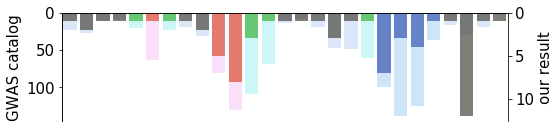

In [1375]:
plt.rcParams["figure.figsize"] = (8,2)
plt.rcParams["font.size"] = 15
plt.rcParams['font.family']='Arial'

ax=sns.barplot(x='index',y='gene_name',data=phewas_data_2d_columns_catalog_all_count,palette=list(phewas_data_2d_columns_catalog_all_count['color'].values),alpha=0.5)
#sns.barplot(x='index',y='gene_name',data=phewas_data_2d_columns_catalog_all_count,palette=list(phewas_data_2d_columns_catalog_all_count['color'].values),alpha=0.5)



#ax.spines['right'].set_visible(False)
#ax.spines['top'].set_visible(False)
ax.xaxis.set_visible(False)
plt.xticks(fontsize=5)
plt.gca().invert_yaxis()
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.ylabel('GWAS catalog')
#plt.xlabel('ss')

ax2 = ax.twinx() 
ax2=sns.barplot(x='gene',y=0,data=phewas_data_2d_count,palette=list(phewas_data_2d_count['color'].values),alpha=0.7)
plt.gca().invert_yaxis()
ax2.spines['bottom'].set_visible(False)
plt.ylabel('our result')

plt.savefig('figure_phewas2.svg', bbox_inches='tight')

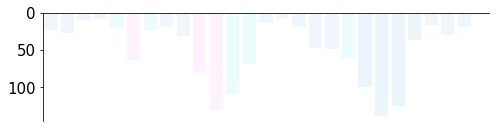

In [1374]:
plt.rcParams["figure.figsize"] = (8,2)
plt.rcParams["font.size"] = 15
plt.rcParams['font.family']='Arial'
ax=sns.barplot(x='index',y='gene_name',data=phewas_data_2d_columns_catalog_all_count,palette=list(phewas_data_2d_columns_catalog_all_count['color'].values),alpha=0.2)
#sns.barplot(x='index',y='gene_name',data=phewas_data_2d_columns_catalog_all_count,palette=list(phewas_data_2d_columns_catalog_all_count['color'].values),alpha=0.5)

plt.ylabel('')
plt.xlabel('')

#ax.spines['right'].set_visible(False)
#ax.spines['top'].set_visible(False)
ax.xaxis.set_visible(False)
plt.xticks(fontsize=5)
plt.gca().invert_yaxis()
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.savefig('figure_phewas2.svg', bbox_inches='tight')

In [1314]:
#phewas_data_2d_columns_catalog_all

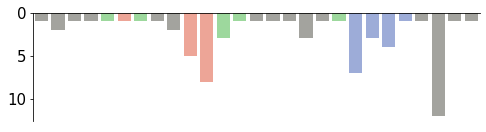

In [1326]:
plt.rcParams["figure.figsize"] = (8,2)
plt.rcParams["font.size"] = 15
plt.rcParams['font.family']='Arial'
ax=sns.barplot(x='gene',y=0,data=phewas_data_2d_count,palette=list(phewas_data_2d_count['color'].values),alpha=0.5)
#sns.barplot(x='index',y='gene_name',data=phewas_data_2d_columns_catalog_all_count,palette=list(phewas_data_2d_columns_catalog_all_count['color'].values),alpha=0.5)

plt.ylabel('')
plt.xlabel('')

#ax.spines['right'].set_visible(False)
#ax.spines['top'].set_visible(False)
ax.xaxis.set_visible(False)
plt.xticks(fontsize=5)
plt.gca().invert_yaxis()
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.savefig('figure_phewas2.svg', bbox_inches='tight')

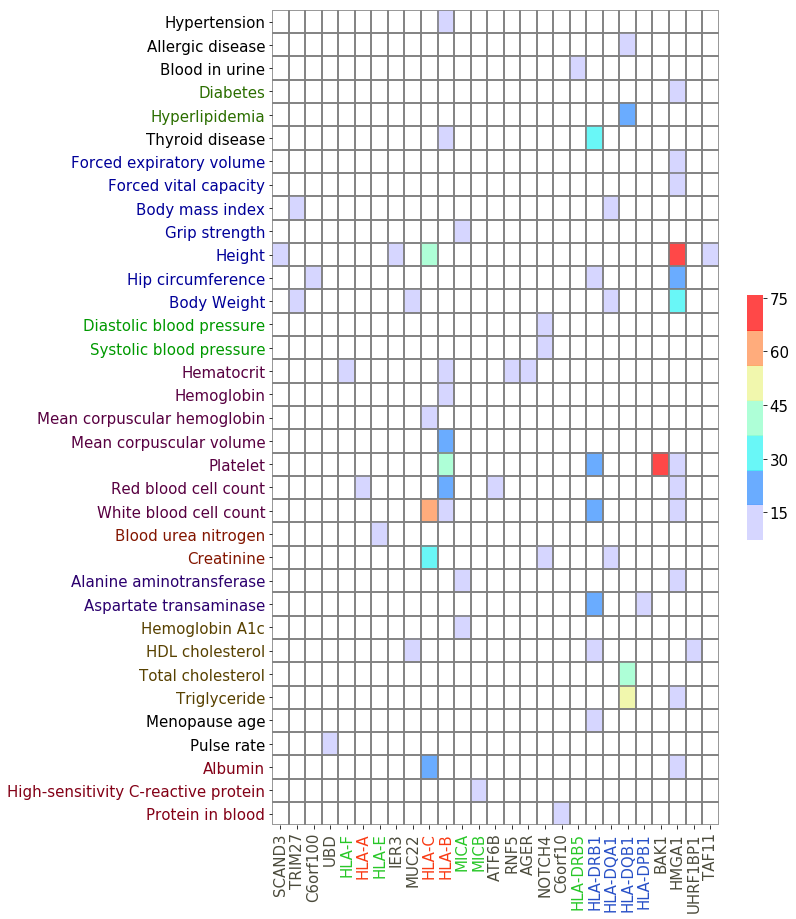

In [1295]:
plt.rcParams["figure.figsize"] = (10,15)
plt.rcParams["font.size"] = 15
plt.rcParams['font.family']='Arial'

import seaborn as sns
ax=sns.heatmap(phewas_data_2d,cmap=custom_cmap,vmin=-np.log10(5e-8),linewidths=1, linecolor='grey',cbar_kws={"shrink": 0.3,'aspect':15},alpha=0.8)#,legend=None)
#ax.legend().set_visible(False)
#ax.legend.
#ax.xaxis.set_ticks_position('top')
#plt.xticks(rotation=90)

plt.ylabel('')
plt.xlabel('')

for ticklabel in ax.yaxis.get_ticklabels():
    phenotype_name=ticklabel.get_text()
    phenotype_category=phenotype_info.loc[phenotype_name]['phenotype_category']
    ticklabel.set_color(phenotype_category_color.loc[phenotype_category])
ax.set_yticklabels([phenotype_info.loc[item.get_text()]['phenotype_name_publication'] for item in ax.get_yticklabels()])

for ticklabel in ax.xaxis.get_ticklabels():
    gene_name=ticklabel.get_text()
    ticklabel.set_color(gene_to_color(gene_name))
    """
    if gene_name in ['HLA-A','HLA-B','HLA-C']:
        ticklabel.set_color('#fa3c14')
    elif gene_name in ['HLA-DPA1', 'HLA-DPB1','HLA-DQA1', 'HLA-DQB1','HLA-DRB1','HLA-DRA']:
        ticklabel.set_color(color='#2850c8')
    elif gene_name in ['HLA-F', 'HLA-G', 'HLA-E', 'HLA-DRB5', 'HLA-DQA2', 'HLA-DQB2', 'HLA-DOB', 'HLA-DMB', 'HLA-DMA', 'HLA-DOA', 'MICA','MICB','TAP2','TAP1']:
        ticklabel.set_color('#28c828')
    """
#plt.show()

plt.savefig('figure_phewas.svg', bbox_inches='tight')

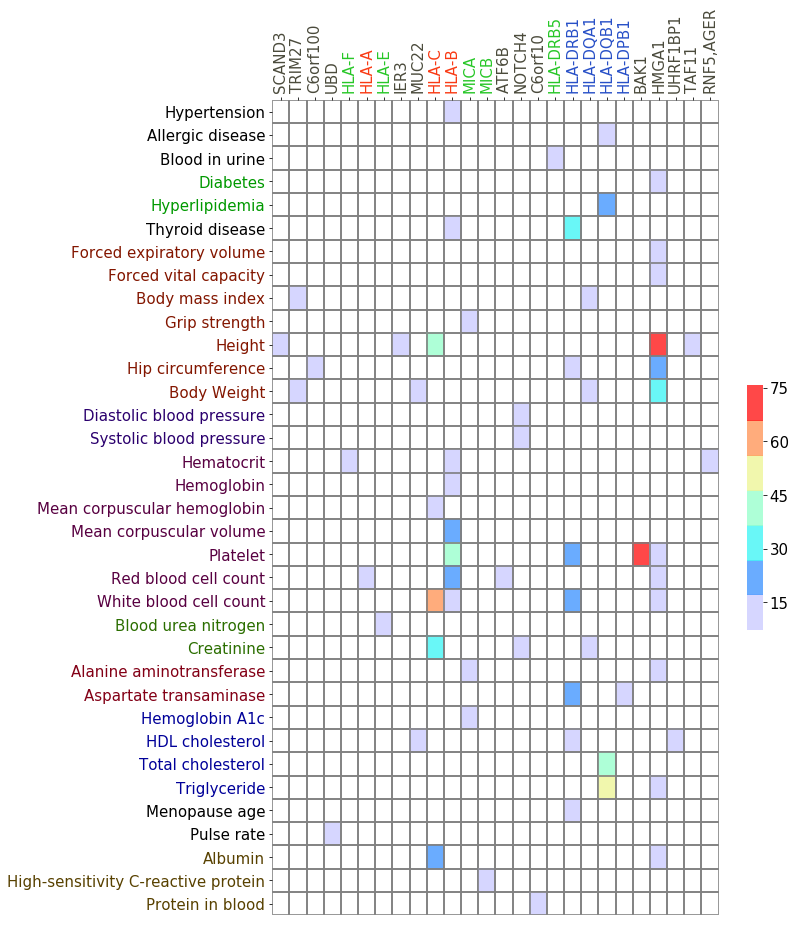

In [1032]:
plt.rcParams["figure.figsize"] = (10,15)
plt.rcParams["font.size"] = 15
plt.rcParams['font.family']='Arial'

import seaborn as sns
ax=sns.heatmap(phewas_data_2d,cmap=custom_cmap,vmin=-np.log10(5e-8),linewidths=1, linecolor='grey',cbar_kws={"shrink": 0.3,'aspect':15},alpha=0.8)#,legend=None)
#ax.legend().set_visible(False)
#ax.legend.
ax.xaxis.set_ticks_position('top')
plt.xticks(rotation=90)

plt.ylabel('')
plt.xlabel('')

for ticklabel in ax.yaxis.get_ticklabels():
    phenotype_name=ticklabel.get_text()
    phenotype_category=phenotype_info.loc[phenotype_name]['phenotype_category']
    ticklabel.set_color(phenotype_category_color.loc[phenotype_category])
ax.set_yticklabels([phenotype_info.loc[item.get_text()]['phenotype_name_publication'] for item in ax.get_yticklabels()])

for ticklabel in ax.xaxis.get_ticklabels():
    gene_name=ticklabel.get_text()
    ticklabel.set_color(gene_to_color(gene_name))

plt.show()

In [989]:
phenotype_info

,phenotype_name_publication,phenotype_category,phenotype_type
phenotype_name,,,
bladder_cancer,Bladder cancer,Cancer,binary
breast_cancer,Breast cancer,Cancer,binary
cervical_cancer,Cervical cancer,Cancer,binary
colorectal_cancer,Colorectal cancer,Cancer,binary
liver_cancer,Liver cancer,Cancer,binary
lung_cancer,Lung cancer,Cancer,binary
prostate_cancer,Prostate cancer,Cancer,binary
stomach_cancer,Stomach cancer,Cancer,binary
thyroid_cancer,Thryroid cancer,Cancer,binary


Index(['hypertension', 'allergic_disease', 'blood_in_urine', 'diabetes',
       'hyperlipidemia', 'thyroid_disease', 'FEV_predicted', 'FVC_predicted',
       'bmi', 'grip_strength', 'height', 'hip_circumference', 'weight',
       'diastolic_blood_pressure', 'systolic_blood_pressure', 'hematocrit',
       'hemoglobin', 'mch', 'mcv', 'platelet', 'rbc', 'wbc', 'bun',
       'creatinine', 'alt', 'ast', 'hba1c', 'hdl_cholesterol',
       'total_cholesterol', 'triglyceride', 'menopause_age', 'pulse',
       'albumin', 'hscrp', 'protein_in_blood'],
      dtype='object', name='phenotype_name')

In [450]:
phenotype_info.sort_values(['phenotype_type','phenotype_category'])#.sort_values('phenotype_category')

,phenotype_name_publication,phenotype_category,phenotype_type
phenotype_name,,,
bladder_cancer,Bladder cancer,Cancer,binary
breast_cancer,Breast cancer,Cancer,binary
cervical_cancer,Cervical cancer,Cancer,binary
colorectal_cancer,Colorectal cancer,Cancer,binary
liver_cancer,Liver cancer,Cancer,binary
lung_cancer,Lung cancer,Cancer,binary
prostate_cancer,Prostate cancer,Cancer,binary
stomach_cancer,Stomach cancer,Cancer,binary
thyroid_cancer,Thryroid cancer,Cancer,binary


In [443]:
gene_bed.set_index('Gene name').loc[phewas_data_2d.columns].sort_values('Gene start (bp)').index#.index#.duplicated().sum()

/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


Index(['SCAND3', 'TRIM27', 'C6orf100', 'UBD', 'HLA-F', 'HLA-A', 'HLA-E',
       'IER3', 'MUC22', 'HLA-C', 'HLA-B', 'MICA', 'MICB', 'ATF6B', 'NOTCH4',
       'C6orf10', 'HLA-DRB5', 'HLA-DRB1', 'HLA-DQA1', 'HLA-DQB1', 'HLA-DPB1',
       'BAK1', 'HMGA1', 'UHRF1BP1', 'TAF11', 'RNF5,AGER'],
      dtype='object', name='gene')

Index(['ATF6B', 'BAK1', 'C6orf10', 'C6orf100', 'HLA-A', 'HLA-B', 'HLA-C',
       'HLA-DPB1', 'HLA-DQA1', 'HLA-DQB1', 'HLA-DRB1', 'HLA-DRB5', 'HLA-E',
       'HLA-F', 'HMGA1', 'IER3', 'MICA', 'MICB', 'MUC22', 'NOTCH4',
       'RNF5,AGER', 'SCAND3', 'TAF11', 'TRIM27', 'UBD', 'UHRF1BP1'],
      dtype='object', name='gene')

In [408]:
phewas_data['count']=1

In [410]:
phewas_data.pivot('count')

KeyError: None

In [333]:
#catalog_chr6_short[catalog_chr6_short['DISEASE/TRAIT'].str.contains('hemoglobin')]

In [328]:
catalog_temp.columns

Index(['Allele', 'CHR_POS', 'CNV', 'CONTEXT', 'Category', 'DISEASE/TRAIT',
       'DOWNSTREAM_GENE_DISTANCE', 'DOWNSTREAM_GENE_ID', 'INITIAL SAMPLE SIZE',
       'INTERGENIC', 'MAPPED_GENE', 'MAPPED_TRAIT', 'P-VALUE',
       'P-VALUE (TEXT)', 'PUBMEDID', 'REPORTED GENE(S)', 'SNPS',
       'SNP_GENE_IDS', 'SNP_ID_CURRENT', 'STUDY', 'UPSTREAM_GENE_DISTANCE',
       'UPSTREAM_GENE_ID', 'GENE_CUSTOM', 'REPORTED_GENE_CUSTOM',
       'GENE_CUSTOM_REPORTED_GENE_CUSTOM'],
      dtype='object')

In [320]:
result_all[result_all['phenotype_name']=='hscrp']

,Unnamed: 0,Unnamed: 0.1,phenotype_name,samples(case/control),step,condition,marker_name,note,term,POS,...,Z,coef,std,chisq,df,P,P_significant,gene_genehow,gene,genehow
87,33113,264088,hscrp,99904,1,NaN,6:31538497_T/A,unphased bialleic,ADD,31538497,...,-5.82507,-0.004091,0.000702,NaN,NaN,5.726200e-09,1,"('LTA', 'nearest')",LTA,nearest
88,32121,288171,hscrp,99904,2,6:31538497_T/A,6:31442731_T/A,unphased bialleic,ADD,31442731,...,-4.79197,-0.003449,0.000720,NaN,NaN,1.653840e-06,0,NaN,NaN,NaN


In [311]:
31371356-31347274,31347274-31321649

(24082, 25625)

In [ ]:
31538497_

In [316]:
gene_bed[gene_bed['Gene name']=='TAP1'].iloc[0]

Gene stable ID                                                                  ENSG00000168394
Gene stable ID version                                                        ENSG00000168394.9
Transcript stable ID                                                            ENST00000354258
Transcript stable ID version                                                  ENST00000354258.4
Gene start (bp)                                                                        32812986
Gene end (bp)                                                                          32821755
Transcript start (bp)                                                                  32812986
Transcript end (bp)                                                                    32821755
Protein stable ID                                                               ENSP00000346206
Protein stable ID version                                                     ENSP00000346206.4
Gene description                        

In [313]:
gene_bed[gene_bed['Gene description'].str.contains('MHC')]

,Gene stable ID,Gene stable ID version,Transcript stable ID,Transcript stable ID version,Gene start (bp),Gene end (bp),Transcript start (bp),Transcript end (bp),Protein stable ID,Protein stable ID version,...,Transcript count,Source of transcript name,Transcript name,Source of gene name,Gene name,GENCODE basic annotation,Transcript length (including UTRs and CDS),Gene stable ID38,Gene start (bp)38,Gene end (bp)38
2123096,ENSG00000204520,ENSG00000204520.8,ENST00000449934,ENST00000449934.2,31371356,31383092,31371356,31383092,ENSP00000413079,ENSP00000413079.1,...,2,HGNC transcript name,MICA-001,HGNC Symbol,MICA,1.0,1386,ENSG00000204520,31399784.0,31415315.0
2123486,ENSG00000204516,ENSG00000204516.5,ENST00000399150,ENST00000399150.3,31462658,31478901,31465863,31478901,ENSP00000382103,ENSP00000382103.3,...,5,HGNC transcript name,MICB-002,HGNC Symbol,MICB,1.0,2346,ENSG00000204516,31494881.0,31511124.0
4062867,ENSG00000204290,ENSG00000204290.6,ENST00000454136,ENST00000454136.3,32361740,32374905,32361740,32374905,ENSP00000390613,ENSP00000390613.3,...,9,HGNC transcript name,BTNL2-001,HGNC Symbol,BTNL2,1.0,1460,ENSG00000204290,32393963.0,32407128.0


In [322]:
gene_bed.loc[(gene_bed['Gene start (bp)']-31538497).abs().sort_values().index]

,Gene stable ID,Gene stable ID version,Transcript stable ID,Transcript stable ID version,Gene start (bp),Gene end (bp),Transcript start (bp),Transcript end (bp),Protein stable ID,Protein stable ID version,...,Transcript count,Source of transcript name,Transcript name,Source of gene name,Gene name,GENCODE basic annotation,Transcript length (including UTRs and CDS),Gene stable ID38,Gene start (bp)38,Gene end (bp)38
2187189,ENSG00000226979,ENSG00000226979.4,ENST00000454783,ENST00000454783.1,31539831,31542101,31539831,31542101,ENSP00000403495,ENSP00000403495.1,...,4,HGNC transcript name,LTA-002,HGNC Symbol,LTA,1.0,1507,ENSG00000226979,31572054.0,31574324.0
2187777,ENSG00000232810,ENSG00000232810.3,ENST00000449264,ENST00000449264.2,31543344,31546113,31543344,31546113,ENSP00000398698,ENSP00000398698.2,...,1,HGNC transcript name,TNF-001,HGNC Symbol,TNF,1.0,1676,ENSG00000232810,31575565.0,31578336.0
2187949,ENSG00000227507,ENSG00000227507.2,ENST00000429299,ENST00000429299.2,31548302,31550299,31548332,31550202,ENSP00000410481,ENSP00000410481.2,...,4,HGNC transcript name,LTB-001,HGNC Symbol,LTB,1.0,897,ENSG00000227507,31580525.0,31582522.0
2188273,ENSG00000204482,ENSG00000204482.6,ENST00000418507,ENST00000418507.2,31553901,31556686,31553901,31556686,ENSP00000405900,ENSP00000405900.2,...,24,HGNC transcript name,LST1-011,HGNC Symbol,LST1,1.0,726,ENSG00000204482,31586124.0,31588909.0
2205633,ENSG00000204475,ENSG00000204475.5,ENST00000340027,ENST00000340027.5,31556672,31560762,31556672,31560762,ENSP00000342156,ENSP00000342156.5,...,6,HGNC transcript name,NCR3-001,HGNC Symbol,NCR3,1.0,1042,ENSG00000204475,31588895.0,31593006.0
2186467,ENSG00000204498,ENSG00000204498.6,ENST00000376146,ENST00000376146.4,31514647,31526606,31514647,31526606,ENSP00000365316,ENSP00000365316.4,...,5,HGNC transcript name,NFKBIL1-003,HGNC Symbol,NFKBIL1,NaN,1411,ENSG00000204498,31546870.0,31558829.0
2185022,ENSG00000213760,ENSG00000213760.6,ENST00000376151,ENST00000376151.4,31512239,31516204,31512239,31514414,ENSP00000365321,ENSP00000365321.4,...,6,HGNC transcript name,ATP6V1G2-002,HGNC Symbol,ATP6V1G2,1.0,1261,ENSG00000213760,31544462.0,31548427.0
2127794,ENSG00000198563,ENSG00000198563.9,ENST00000376177,ENST00000376177.2,31497996,31510225,31497996,31508313,ENSP00000365347,ENSP00000365347.2,...,25,HGNC transcript name,DDX39B-006,HGNC Symbol,DDX39B,1.0,1529,ENSG00000198563,31530219.0,31542448.0
2123980,ENSG00000204511,ENSG00000204511.2,ENST00000376191,ENST00000376191.2,31496494,31498009,31496494,31498009,ENSP00000365362,ENSP00000365362.2,...,1,HGNC transcript name,MCCD1-001,HGNC Symbol,MCCD1,1.0,955,ENSG00000204511,31528962.0,31530232.0
2207335,ENSG00000204472,ENSG00000204472.8,ENST00000376059,ENST00000376059.3,31582961,31584798,31582961,31584798,ENSP00000365227,ENSP00000365227.3,...,5,HGNC transcript name,AIF1-001,HGNC Symbol,AIF1,1.0,711,ENSG00000204472,31615217.0,31617021.0


In [314]:
'TAP1' in gene_bed['Gene name'].values

True

In [65]:
gene_to_name=lambda x: gene_bed_indexed.loc[x.split(',')] if type(x)==str else x

catalog_chr6_short['SNP_GENE_IDS'].map(gene_to_name)

/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


KeyError: "None of [Index(['ENSG00000206337'], dtype='object', name='Gene stable ID')] are in the [index]"

In [ ]:
for idx,row in catalog_chr6_short.iterrows():
    print(row['DISEASE/TRAIT'],'-----',row['MAPPED_TRAIT'])
    
    if idx==1000:
        break

In [55]:
catalog_chr6_short['DISEASE/TRAIT'].unique()

array(["Crohn's disease", 'Ulcerative colitis',
       'Alcohol consumption (transferrin glycosylation)', ...,
       'Educational attainment (MTAG)', 'Cognitive performance (MTAG)',
       'Self-reported math ability'], dtype=object)

In [56]:
catalog_chr6_short['MAPPED_TRAIT'].unique()

array(["Crohn's disease", 'ulcerative colitis', 'alcohol drinking', ...,
       'chronic kidney disease, APOL1 risk genotype carrier status',
       'Microalbuminuria, type I diabetes mellitus',
       'response to ketogenic diet, epilepsy'], dtype=object)

In [ ]:
catalog_chr6_short[catalog_chr6_short['DOWNSTREAM_GENE_DISTANCE'].isnull()]